# Desafio: Predição de clientes bons - STEFANINI

### Autor: Matheus Jericó Palhares
### e-mail: matheusjerico1994@hotmail.com
### data: 18/07/2019

#### Definição do dataset:
- Account No. - representa o número da conta envolvida na transação.
- Date - data da transação.
- Transaction Details - narrações de transação em extratos bancários.
- Cheque No. - indica o número do cheque.
- Value Date - Data de conclusão da transação.
- Withdrawal Amount - Indica o montante retirado.
- Deposit Amount - Indica o valor depositado.
- Balance Amount - saldo atual da conta.

#### Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import seaborn as sns
%matplotlib inline

#### 1. Importando dataset

In [2]:
path_xlsx = '/home/matheusjerico/Documentos/IA/Desafio_LSTM/bank.xlsx'

dataset = pd.read_excel(path_xlsx, sep=',')

#### 2. Pré Processamento dos dados

In [3]:
dataset.head()

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.


In [4]:
dataset.shape

(116201, 9)

#### 2.1. Renomeando as colunas

In [5]:
dataset = dataset.rename(columns={'Account No':'ACCOUNT_NO', 'DATE':'DATE', 'TRANSACTION DETAILS':'TRANSACTION_DETAILS',
                                'CHQ.NO.':'CHQ_NO','VALUE DATE':'VALUE_DATE',
                                'WITHDRAWAL AMT':'WITHDRAWAL_AMT','DEPOSIT AMT':'DEPOSIT_AMT',
                                'BALANCE AMT':'BALANCE_AMT', '.':'.'})

#### 2.2. Visualizando dados faltantes e removendo colunas desnecessárias

In [6]:
dataset.isna().sum()

ACCOUNT_NO                  0
DATE                        0
TRANSACTION_DETAILS      2499
CHQ_NO                 115296
VALUE_DATE                  0
WITHDRAWAL_AMT          62652
DEPOSIT_AMT             53549
BALANCE_AMT                 0
.                           0
dtype: int64

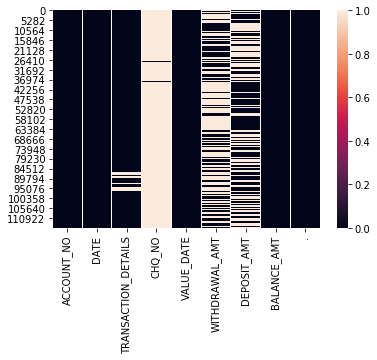

In [7]:
sns.heatmap(dataset.isna())

# 1. Segunda Tarefa - Desafio LSTM

### Verificar em os pontos de melhores clientes

#### 1.1. Pré Processamento

- Remover coluna com muitos valores NaN

In [8]:
df = dataset.drop(columns=['CHQ_NO'])

- Removendo as colunas date, value_date, transaction_details, balance_amt e '.'

In [9]:
df = df.drop(columns=['DATE', 'VALUE_DATE','TRANSACTION_DETAILS','.','BALANCE_AMT'])

#### 1.2 Preenchimento de valores NaN
- As colunas WITHDRAWAL_AMT e DEPOSIT_AMT são opostas, quando uma tem valor, a outra não tem.
- Isso ocorre porque nosso dataset é referente transações bancárias. Logo, uma transação de saque não ocorre junto a de depósito.
- Para isso, vamos substituir os valores NaN por 0.

In [10]:
df['WITHDRAWAL_AMT'] = df['WITHDRAWAL_AMT'].fillna(0)
df['DEPOSIT_AMT'] = df['DEPOSIT_AMT'].fillna(0)

- Verificar a existência de valores NaN no novo dataset e obtendo informações referentes ao dataset

In [11]:
df.isna().sum()

ACCOUNT_NO        0
WITHDRAWAL_AMT    0
DEPOSIT_AMT       0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 3 columns):
ACCOUNT_NO        116201 non-null object
WITHDRAWAL_AMT    116201 non-null float64
DEPOSIT_AMT       116201 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.7+ MB


In [13]:
df.head(3)

,ACCOUNT_NO,WITHDRAWAL_AMT,DEPOSIT_AMT
0,409000611074',0.0,1000000.0
1,409000611074',0.0,1000000.0
2,409000611074',0.0,500000.0


#### 1.3 Categorizando as colunas que possuem valores em formato string.

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
df.ACCOUNT_NO = df.ACCOUNT_NO.astype('category')
le = LabelEncoder()
df.ACCOUNT_NO = le.fit_transform(df.ACCOUNT_NO)

- Visualizando correlação entre variáveis

In [16]:
df.corr()

,ACCOUNT_NO,WITHDRAWAL_AMT,DEPOSIT_AMT
ACCOUNT_NO,1.000000,-0.051821,-0.059683
WITHDRAWAL_AMT,-0.051821,1.000000,-0.082927
DEPOSIT_AMT,-0.059683,-0.082927,1.000000


- Verificar a formato dataset e obtendo informações referentes ao dataset

In [17]:
print(df.shape)

(116201, 3)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 3 columns):
ACCOUNT_NO        116201 non-null int64
WITHDRAWAL_AMT    116201 non-null float64
DEPOSIT_AMT       116201 non-null float64
dtypes: float64(2), int64(1)
memory usage: 2.7 MB


#### 1.4 Criando nova columa com saldo do cada número de conta
- Para isso, criei uma nova coluna chamada 'account_balance_positive' para fazer a somatória dos valores depositados por cada conta, de forma acumulativa.
- Criei uma nova coluna chamada 'account_balance_negative' para fazer a somatória dos valores retirados por cada conta, de forma acumulativa.
- Caso uma conta faça o depósito de R$1000,00 5 vezes, o valor da 'account_balance_positive' vai ser acumulativo.
- Após a criação das duas colunas, faço a subtração entre a coluna 'account_balance_positive' com a 'account_balance_negative', obtendo o saldo atual de cada conta após cada transação, uma nova coluna chamada 'account_balance_total'
- Esse novo parâmetro será utilizado para calcular o potencial dos clientes.

In [19]:
# Inicializo as colunas
df['account_balance_positive'] = 0
df['account_balance_negative'] = 0
df['account_balance_total'] = 0

In [20]:
# Calculando os valores positivos por cada conta:
df['account_balance_positive'] = df.groupby(['ACCOUNT_NO'])['DEPOSIT_AMT'].cumsum()

In [21]:
# Calculando os valores retirados por cada conta:
df['account_balance_negative'] = df.groupby(['ACCOUNT_NO'])['WITHDRAWAL_AMT'].cumsum()

In [22]:
# Fazendo a subtração entre as duas colunas:
df['account_balance_total'] = df['account_balance_positive'] - df['account_balance_negative']

In [23]:
df.head(5)

,ACCOUNT_NO,WITHDRAWAL_AMT,DEPOSIT_AMT,account_balance_positive,account_balance_negative,account_balance_total
0,9,0.0,1000000.0,1000000.0,0.0,1000000.0
1,9,0.0,1000000.0,2000000.0,0.0,2000000.0
2,9,0.0,500000.0,2500000.0,0.0,2500000.0
3,9,0.0,3000000.0,5500000.0,0.0,5500000.0
4,9,0.0,500000.0,6000000.0,0.0,6000000.0


- Remoção das colunas 'account_balance_positive' e 'account_balance_negative'

In [24]:
df = df.drop(columns=['account_balance_negative', 'account_balance_positive'])

In [25]:
df.head(5)

,ACCOUNT_NO,WITHDRAWAL_AMT,DEPOSIT_AMT,account_balance_total
0,9,0.0,1000000.0,1000000.0
1,9,0.0,1000000.0,2000000.0
2,9,0.0,500000.0,2500000.0
3,9,0.0,3000000.0,5500000.0
4,9,0.0,500000.0,6000000.0


#### 1.5 Criando uma nova coluna
- Quando o valor do 'account_balance_total' é negativo, temos um potencial de um cliente que não é bom, pois está com seu dividendo ativo.
- Quando temos um valor positivo, indica que foi inserido um valor maior que retirado.
- Dessa forma, crio uma nova coluna informando se temos um bom potencial ou não.

In [26]:
df['good_client'] = np.where(df.account_balance_total > 0, 1, 0)

#### 1.7 Embaralhando o dataset para retirar ordem cronológica

In [27]:
df=df.iloc[np.random.permutation(len(df))]

#### 1.8 Resetando index

In [28]:
df=df.reset_index(drop=True)
print(df.shape)

(116201, 5)


#### 2. Definição da janela
Definir a janela da LSTM, utilizando o parâmetro 'n_timesteps'. 


In [29]:
n_timesteps = 100

#### 2.1 Separando os dados de treino e teste
O padrão de entrada do tensorflow é:
    - [tamanho_do_batch, tamanho_da_memoria (janela), qntd_atributos]
    - Em cada batch teremos 'n_timesteps' registros, no caso apresentado, 30 registros.

In [30]:
x_input = df.iloc[0:116000,0:4]
X_batch = np.array(x_input).reshape(-1, n_timesteps, 4)
y_input = df.iloc[0:116000,4:5]
y_batch = np.array(y_input).reshape(-1, n_timesteps, 1)


x_test = df.iloc[116000:116200,0:4]
X_teste = np.array(x_test).reshape(-1, n_timesteps, 4)
y_test = df.iloc[116000:116200,4:5]
y_teste = np.array(y_test).reshape(-1, n_timesteps, 1)

#### 3. Algoritmo LSTM

In [31]:
# reset grafo atual
tf.reset_default_graph()

#### 3.1 Parâmetros
- n_inputs: quantidade de atributos previsores. Utilizou-se 4 parâmetros.
- n_nodes: quantidade de neurônios utilizados na camada ocultas. Definido após realizar alguns testes, alterando a quantidade até obter-se um bom resultado
- n_output: quantidade de atributos de saída. Apenas uma saída, que oscila entre 0 e 1. 1 para melhores clientes e 0 para piores clientes

In [32]:
# nº de entradas
n_input = 4
# nodes da camada do LSTM
n_nodes = 100
# nº de saídas
n_output = 1

#### 3.2 Criação dos placeholders

In [33]:
# Criação dos placeholders
x = tf.placeholder(tf.float32,[None, n_timesteps, n_input])
y = tf.placeholder(tf.float32, [None, n_timesteps, n_output])

#### 3.3 Definição de uma célula LSTM
- Cada célula indica uma camada oculta

In [34]:
def criar_uma_celula():
    # Função para criar uma célula LSTM
    # Parâmetros: quantidade de nodes da camada (100), função de ativação (tanh)
    
    return tf.contrib.rnn.LSTMCell(num_units = n_nodes, activation = tf.nn.tanh)

#### 3.4 Função para criar N células (camadas) 
- Foram criadas 3 celúlas LSTM com Dropout.
- O uso de mais de uma célula pode melhorar os resultados.
- A camada de Dropout evita o overfitting do modelo.

In [35]:
def crias_varias_celulas(n_celulas):
    # Inicializo várias células
    celulas = tf.nn.rnn_cell.MultiRNNCell([criar_uma_celula() for i in range(0, n_celulas)])
    # Coloco droupout com valor de 0.1 
    return tf.contrib.rnn.DropoutWrapper(celulas, input_keep_prob= 0.9) # dropout

#### 3.5 Criando células ocultas e célula de saída
- Criação de 3 células e 1 camada de saída;
- Como tem 100 neurônios na camada oculta, preciso transformar em apenas um output (output_size = 1)

In [36]:
# Criando 3 células
celula = crias_varias_celulas(3)
# Criação da camada de saída,
# Apenas uma saída, pois queremos predizer apenas um parâmetro
celula = tf.contrib.rnn.OutputProjectionWrapper(celula, output_size= 1)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


#### 3.6 Criação da LSTM
- É necessário ter a saída da LSTM para calcular o erro, e posteriormente otimizar o erro das previsões.
- saida_lstm é a saída da RN, as predições


In [37]:
saida_lstm,_ = tf.nn.dynamic_rnn(celula, x, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### 3.7 Erros e métricas:
- Função para cálculo do erro: mean_squared_error.
- Otimizador: AdamOptimizer

O otimizador mais adequado, depois de vários testes, foi o Adam com learning rate = 0.001 (valor default). A função de erro escolhida foi a MSE.



In [38]:
# Função para o cálculo do erro
# Parâmetros: o labels e as predições 
erro = tf.losses.mean_squared_error(labels=y, predictions=saida_lstm)
# Otimizador
otimizador = tf.train.AdamOptimizer()
# Treinamento, o objetivo é minimizar o erro
treinamento = otimizador.minimize(erro)

Instructions for updating:
Use tf.cast instead.


#### 3.8 Inicializando variáveis globais


In [39]:
init = tf.global_variables_initializer()

#### 3.9 Definição da quantidade de épocas

In [40]:
epocas = 500
# Definição de quando mostrar as métricas
n_display = epocas/10

#### 4.0 Iniciando sessão do TensorFlow
- Inicializa variáveis;
- Loop de treinamento com duração das epocas definidas acima;
- Rodar treinamento da rede:
    - parâmetros: otimizador do erro, e função para cálculo do erro
- Realizar previsão.

In [41]:
# Inicio a sessão para treinamento e previsão
with tf.Session() as sess:
    sess.run(init)
    # Loop de épocas
    for epoca in range(epocas+1):
        # Faço o treinamento e passo os parâmetros que são utilizados nas funções 
        # 'tf.nn.dynamic_rnn' e 'tf.losses.mean_squared_error'
        _, loss = sess.run([treinamento, erro], feed_dict = {x: X_batch, y: y_batch})
        if epoca % n_display == 0:
            print('Epoca:', epoca, '\terro (MSE):', loss)
    
    # Realizando predições
    previsoes = sess.run(saida_lstm, feed_dict = {x: X_teste})

Epoca: 0 	erro (MSE): 0.40047383
Epoca: 50 	erro (MSE): 0.035123102
Epoca: 100 	erro (MSE): 0.030759502
Epoca: 150 	erro (MSE): 0.026113607
Epoca: 200 	erro (MSE): 0.024743484
Epoca: 250 	erro (MSE): 0.023512581
Epoca: 300 	erro (MSE): 0.02506275
Epoca: 350 	erro (MSE): 0.022968644
Epoca: 400 	erro (MSE): 0.024732158
Epoca: 450 	erro (MSE): 0.024120487
Epoca: 500 	erro (MSE): 0.023998965


### 4. Resultados

Variáveis estão no formato tensor flow (3 dimensões), uso método ravel para mudar suas dimensões

In [42]:
y_teste_normal = np.ravel(y_teste)
print(y_teste.shape)
print(y_teste_normal.shape)

(2, 100, 1)
(200,)


In [43]:
previsoes_normal = np.ravel(previsoes)
print(previsoes.shape)
print(previsoes_normal.shape)

(2, 100, 1)
(200,)


A métrica Classification report mostra as métricas de precision, recall e f1-score



In [44]:
from sklearn.metrics import classification_report


In [45]:
print(classification_report(y_teste_normal, abs(np.around(previsoes_normal)), 
                            target_names= ['Cliente sem potencial', 'Cliente com potencial']))

                       precision    recall  f1-score   support

Cliente sem potencial       0.96      0.98      0.97       120
Cliente com potencial       0.97      0.94      0.96        80

             accuracy                           0.96       200
            macro avg       0.97      0.96      0.96       200
         weighted avg       0.97      0.96      0.96       200

